# Anomaly detection by Informer


## 1. Data preprocessing

In [8]:
from alibi_detect.utils.perturbation import inject_outlier_ts
import pandas as pd

In [9]:
data = pd.read_csv("./dataset/ETDataset/ETTm1.csv")
data.date = pd.to_datetime(data.date)
data = data.set_index('date')

df = data[12*30*24*4+4*30*24*4:]

In [10]:
df

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
date,,,,,,,
2017-10-24 00:00:00,9.980,3.483,7.640,1.812,2.376,0.944,9.215
2017-10-24 00:15:00,9.243,3.282,7.533,2.097,2.376,1.066,9.004
2017-10-24 00:30:00,9.176,2.679,6.858,1.706,2.163,0.853,9.004
2017-10-24 00:45:00,8.306,2.679,6.076,0.817,2.132,0.883,8.934
2017-10-24 01:00:00,8.306,2.143,6.290,0.995,2.010,0.822,9.145
...,...,...,...,...,...,...,...
2018-06-26 18:45:00,9.310,3.550,5.437,1.670,3.868,1.462,9.567
2018-06-26 19:00:00,10.114,3.550,6.183,1.564,3.716,1.462,9.567
2018-06-26 19:15:00,10.784,3.349,7.000,1.635,3.746,1.432,9.426


In [112]:
import numpy as np
arr_df = np.array(df)
np.random.seed(0)

perc_outlier = 10
perc_window = 10
n_std = 2
min_std = 3

arr_df_origin = arr_df.copy()
outlier_df = inject_outlier_ts(arr_df, perc_outlier=perc_outlier, perc_window=perc_window, n_std=n_std, min_std=min_std)
x = outlier_df.data
y = outlier_df.target

In [113]:
df = pd.DataFrame(data=x, index=df.index, columns=df.columns, dtype=None, copy=None)
df_y = pd.DataFrame(list(map(int,y)))

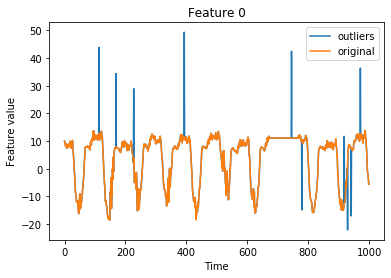

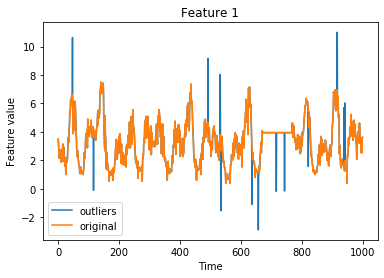

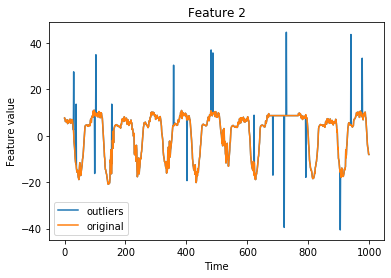

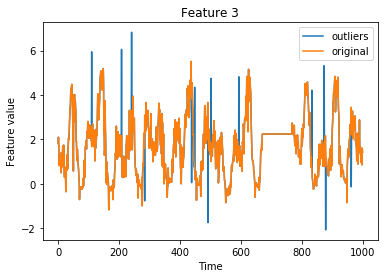

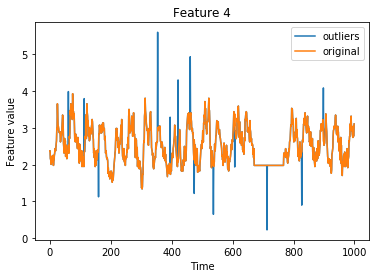

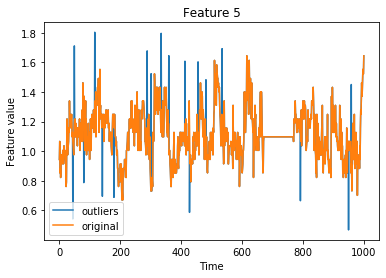

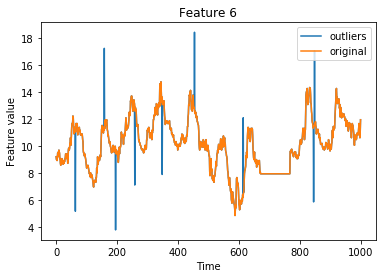

In [114]:
import matplotlib.pyplot as plt
istart, istop = 0, 1000
for f in range(7):
    plt.plot(x[istart:istop, f], label='outliers')
    plt.plot(arr_df_origin[istart:istop, f], label='original')
    plt.title('Feature {}'.format(f))
    plt.xlabel('Time')
    plt.ylabel('Feature value')
    plt.legend()
    plt.show()

In [115]:
import joblib
scaler = joblib.load('./dataset/ETDataset/ETT_standard_scaler.pkl')
trans_df = scaler.transform(df)
norm_data = pd.DataFrame(data=trans_df, index=df.index, columns=df.columns, dtype=None, copy=None)

In [116]:
add_name = f'perc_outlier{perc_outlier},perc_window{perc_window},n_std{n_std},min_std{min_std}'
norm_data.to_csv("./dataset/ETDataset/ETT_Attack_standard_normalised_normal,"+add_name+".csv", mode='w')
df_y.to_csv("./dataset/ETDataset/ETT_Attack_label,"+add_name+".csv", mode='w')

In [18]:
norm_data = pd.read_csv("./dataset/ETDataset/ETT_Attack_standard_normalised_normal.csv")
#norm_data = norm_data.set_index('date')
#norm_data.date = pd.to_datetime(norm_data.date)
#norm_data = norm_data.set_index('date')

In [19]:
norm_data

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2017-10-24 00:00:00,0.206466,0.650537,0.345434,0.556196,-0.418952,0.186585,-0.785820
1,2017-10-24 00:15:00,0.062480,0.560223,0.322725,0.695938,-0.418952,0.390237,-0.807049
2,2017-10-24 00:30:00,0.049391,0.289283,2.295300,0.504222,-0.613020,0.034681,-0.807049
3,2017-10-24 00:45:00,5.820407,0.917458,0.013496,0.068324,-0.641265,0.084759,-0.814092
4,2017-10-24 01:00:00,-0.120579,0.048446,0.058915,0.155601,-0.752421,-0.017067,-0.792863
...,...,...,...,...,...,...,...,...
23595,2018-06-26 18:45:00,0.075570,0.680642,-0.122123,0.486570,0.940433,1.051272,-0.750404
23596,2018-06-26 19:00:00,0.232646,0.680642,0.036206,0.434596,0.801944,1.051272,-0.750404
23597,2018-06-26 19:15:00,0.363542,0.590328,0.209603,0.469409,0.829277,1.001193,-0.764590
23598,2018-06-26 19:30:00,0.533708,0.710746,0.322725,0.504222,1.218324,1.153098,-0.764590


In [15]:
df_y = pd.read_csv("./dataset/WADI/WADI_Attack_label.csv")
df_y.date = pd.to_datetime(df_y.date)
df_y = df_y.set_index('date')

In [ ]:
# 일단 안해줘도 될듯 
val_df = norm_data.iloc[37440:37440+6120]
test_df = norm_data.iloc[37440+6120:]

## 2.Time Series Forecasting 

In [1]:
from utils.tools import dotdict
from exp.exp_informer import Exp_Informer
import torch
import os

In [2]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [3]:
# Exp = Exp_Informer
# exp = Exp(args)
# setting = 'informer_SWaT_ftM_sl1080_ll720_pl360_dm512_nh8_el6_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0'
# path = os.path.join(exp.args.checkpoints, setting)
# best_model_path = path+'/'+'checkpoint.pth'
# exp.model.load_state_dict(torch.load(best_model_path))

In [2]:
import os
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
# from sklearn.preprocessing import StandardScaler

from utils.tools import StandardScaler
from utils.timefeatures import time_features

import warnings
warnings.filterwarnings('ignore')

class Dataset_ETT_minute_anomaly(Dataset):
    def __init__(self, root_path, flag='train', size=None, 
                 features='S', data_path='ETTh1.csv', 
                 target='OT', scale=False, inverse=False, timeenc=0, freq='h', cols=None, val_test_split=10000):
        # size [seq_len, label_len, pred_len]
        # info
        if size == None:
            self.seq_len = 24*4*4
            self.label_len = 24*4
            self.pred_len = 24*4
        else:
            self.seq_len = size[0]
            self.label_len = size[1]
            self.pred_len = size[2]
        # init
        assert flag in ['test', 'val']
        type_map = {'val':0, 'test':1}
        self.set_type = type_map[flag]
        
        self.features = features
        self.target = target
        self.scale = scale
        self.inverse = inverse
        self.timeenc = timeenc
        self.freq = freq
        
        self.root_path = root_path
        self.data_path = data_path
        self.val_test_split = val_test_split
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = pd.read_csv(os.path.join(self.root_path,
                                          self.data_path))
        border1s = [0, self.val_test_split - self.seq_len]
        border2s = [self.val_test_split, len(df_raw)]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]
        
        if self.features=='M' or self.features=='MS':
            cols_data = df_raw.columns[1:]
            df_data = df_raw[cols_data]
        elif self.features=='S':
            df_data = df_raw[[self.target]]

        if self.scale:
            train_data = df_data[border1s[0]:border2s[0]]
            self.scaler.fit(train_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values
            
        df_stamp = df_raw[['date']][border1:border2]
        df_stamp['date'] = pd.to_datetime(df_stamp.date)
        data_stamp = time_features(df_stamp, timeenc=self.timeenc, freq=self.freq)

        self.data_x = data[border1:border2]
        if self.inverse:
            self.data_y = df_data.values[border1:border2]
        else:
            self.data_y = data[border1:border2]
        self.data_stamp = data_stamp
    
    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len 
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]

        return seq_x, seq_y, seq_x_mark, seq_y_mark
    
    def __len__(self):
        return len(self.data_x) - self.seq_len- self.pred_len + 1

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)

In [3]:
from utils.metrics import metric
import numpy as np

def predict(setting, val_test='val', load=True):
        test_data, test_loader = data_set, data_loader
        
        if load:
            path = os.path.join(exp.args.checkpoints, setting)
            best_model_path = path+'/'+'checkpoint.pth'
            exp.model.load_state_dict(torch.load(best_model_path))

        exp.model.eval()
        
        preds = []
        trues = []
        
        for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(test_loader):
            if i%args.pred_len == 0 or i+1==len(test_loader):
                #print('{}/{} step'.format(i, len(test_loader)))
                pred, true = _process_one_batch(
                    test_data, batch_x, batch_y, batch_x_mark, batch_y_mark)
                preds.append(pred.detach().cpu().numpy())
                trues.append(true.detach().cpu().numpy())

        preds = np.array(preds)
        trues = np.array(trues)
        
        print('test shape:', preds.shape, trues.shape)
        preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
        trues = trues.reshape(-1, trues.shape[-2], trues.shape[-1])
        print('test shape:', preds.shape, trues.shape)

        # result save
        folder_path = './results/anomaly/ETTm1/'+attn+','+str(distil)+'/' + setting +'/'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        mae, mse, rmse, mape, mspe = metric(preds, trues)
        print('mse:{}, mae:{}'.format(mse, mae))

        np.save(folder_path+val_test+'_metrics.npy', np.array([mae, mse, rmse, mape, mspe]))
        np.save(folder_path+val_test+'_pred.npy', preds)
        np.save(folder_path+val_test+'_true.npy', trues)

        return


In [4]:
def _process_one_batch(dataset_object, batch_x, batch_y, batch_x_mark, batch_y_mark):
        batch_x = batch_x.float().to(exp.device)
        batch_y = batch_y.float()
        batch_x_mark = batch_x_mark.float().to(exp.device)
        batch_y_mark = batch_y_mark.float().to(exp.device)

        # decoder input
        if exp.args.padding==0:
            dec_inp = torch.zeros([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        elif exp.args.padding==1:
            dec_inp = torch.ones([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        else:
            dec_inp = torch.zeros([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        dec_inp = torch.cat([batch_y[:,:exp.args.label_len,:], dec_inp], dim=1).float().to(exp.device)
        # encoder - decoder
        if exp.args.use_amp:
            with torch.cuda.amp.autocast():
                if exp.args.output_attention:
                    outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                else:
                    outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        else:
            if exp.args.output_attention:
                outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
            else:
                outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        f_dim = -1 if exp.args.features=='MS' else 0
        batch_y = batch_y[:,-exp.args.pred_len:,f_dim:].to(exp.device)

        return outputs, batch_y

In [67]:
# 48 24
# 96 48
# 192 96
# 384 192
# 768 384
# 1152 576
setting = 'informer_ETTm1_ftM_sl384_ll192_pl48_dm512_nh8_el4_dl2_df2048_atfull_fc5_ebtimeF_dtFalse_mxTrue_exp_0'
set_str = setting.split('_')

seq_len = int(set_str[3][2:])
label_len = int(set_str[4][2:])
attn = set_str[-7][2:]
distil = set_str[-4][2:] == 'True'
seq_len, label_len, attn, distil

(384, 192, 'full', False)

In [68]:
# 12. Informerstack(lr=0.0001)
args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'ETTm1' # data
args.root_path = './dataset/ETDataset/' # root path of data file
args.data_path = 'ETT_Attack_standard_normalised_normal,perc_outlier10,perc_window10,n_std2,min_std3.csv' # data file
args.features = 'M' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'OT' # target feature in S or MS task
args.freq = 't' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints

# 4*12=48, 4*12*2=96, 4*12*4=192, 4*12*8=384, 4*12*16=768
args.seq_len = seq_len # input sequence length of Informer encoder
args.label_len = label_len # start token length of Informer decoder
args.pred_len = 48 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 7 # encoder input size
args.dec_in = 7 # decoder input size
args.c_out = 7 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 512 # dimension of model
args.n_heads = 8 # num of heads

args.e_layers = 4 # num of encoder layers
#args.s_layers = [3, 2, 1]
args.d_layers = 2 # num of decoder layers
args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = attn # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = distil # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0

args.batch_size = 32 
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type2'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 10
args.patience = 5
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'

In [69]:
Data = Dataset_ETT_minute_anomaly
timeenc = 0 if args.embed!='timeF' else 1
val_test_split = 4*24*30*3 # 3개월, 5개월
flag = 'val'

shuffle_flag = False; drop_last = False; batch_size = 1; freq=args.freq # batch_size를 1로 하는게 좋긴 할듯

data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    target=args.target,
    inverse=args.inverse,
    timeenc=timeenc,
    freq=freq,
    cols=args.cols,
    val_test_split=val_test_split
)
print(flag, len(data_set))
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)


Exp = Exp_Informer
exp = Exp(args)
predict(setting, flag)
torch.cuda.empty_cache()

flag = 'test'

data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    target=args.target,
    inverse=args.inverse,
    timeenc=timeenc,
    freq=freq,
    cols=args.cols,
    val_test_split=val_test_split
)
print(flag, len(data_set))
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)


Exp = Exp_Informer
exp = Exp(args)
predict(setting, flag)
torch.cuda.empty_cache()

val 8209
Use GPU: cuda:0
test shape: (172, 1, 48, 7) (172, 1, 48, 7)
test shape: (172, 48, 7) (172, 48, 7)
mse:0.5834715366363525, mae:0.5247208476066589
test 14913
Use GPU: cuda:0
test shape: (312, 1, 48, 7) (312, 1, 48, 7)
test shape: (312, 48, 7) (312, 48, 7)
mse:0.8569726943969727, mae:0.6289634108543396


In [22]:
path = './results/anomaly/'+setting
val_preds = np.load(path+'/val_pred.npy')
val_trues = np.load(path+'/val_true.npy')

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


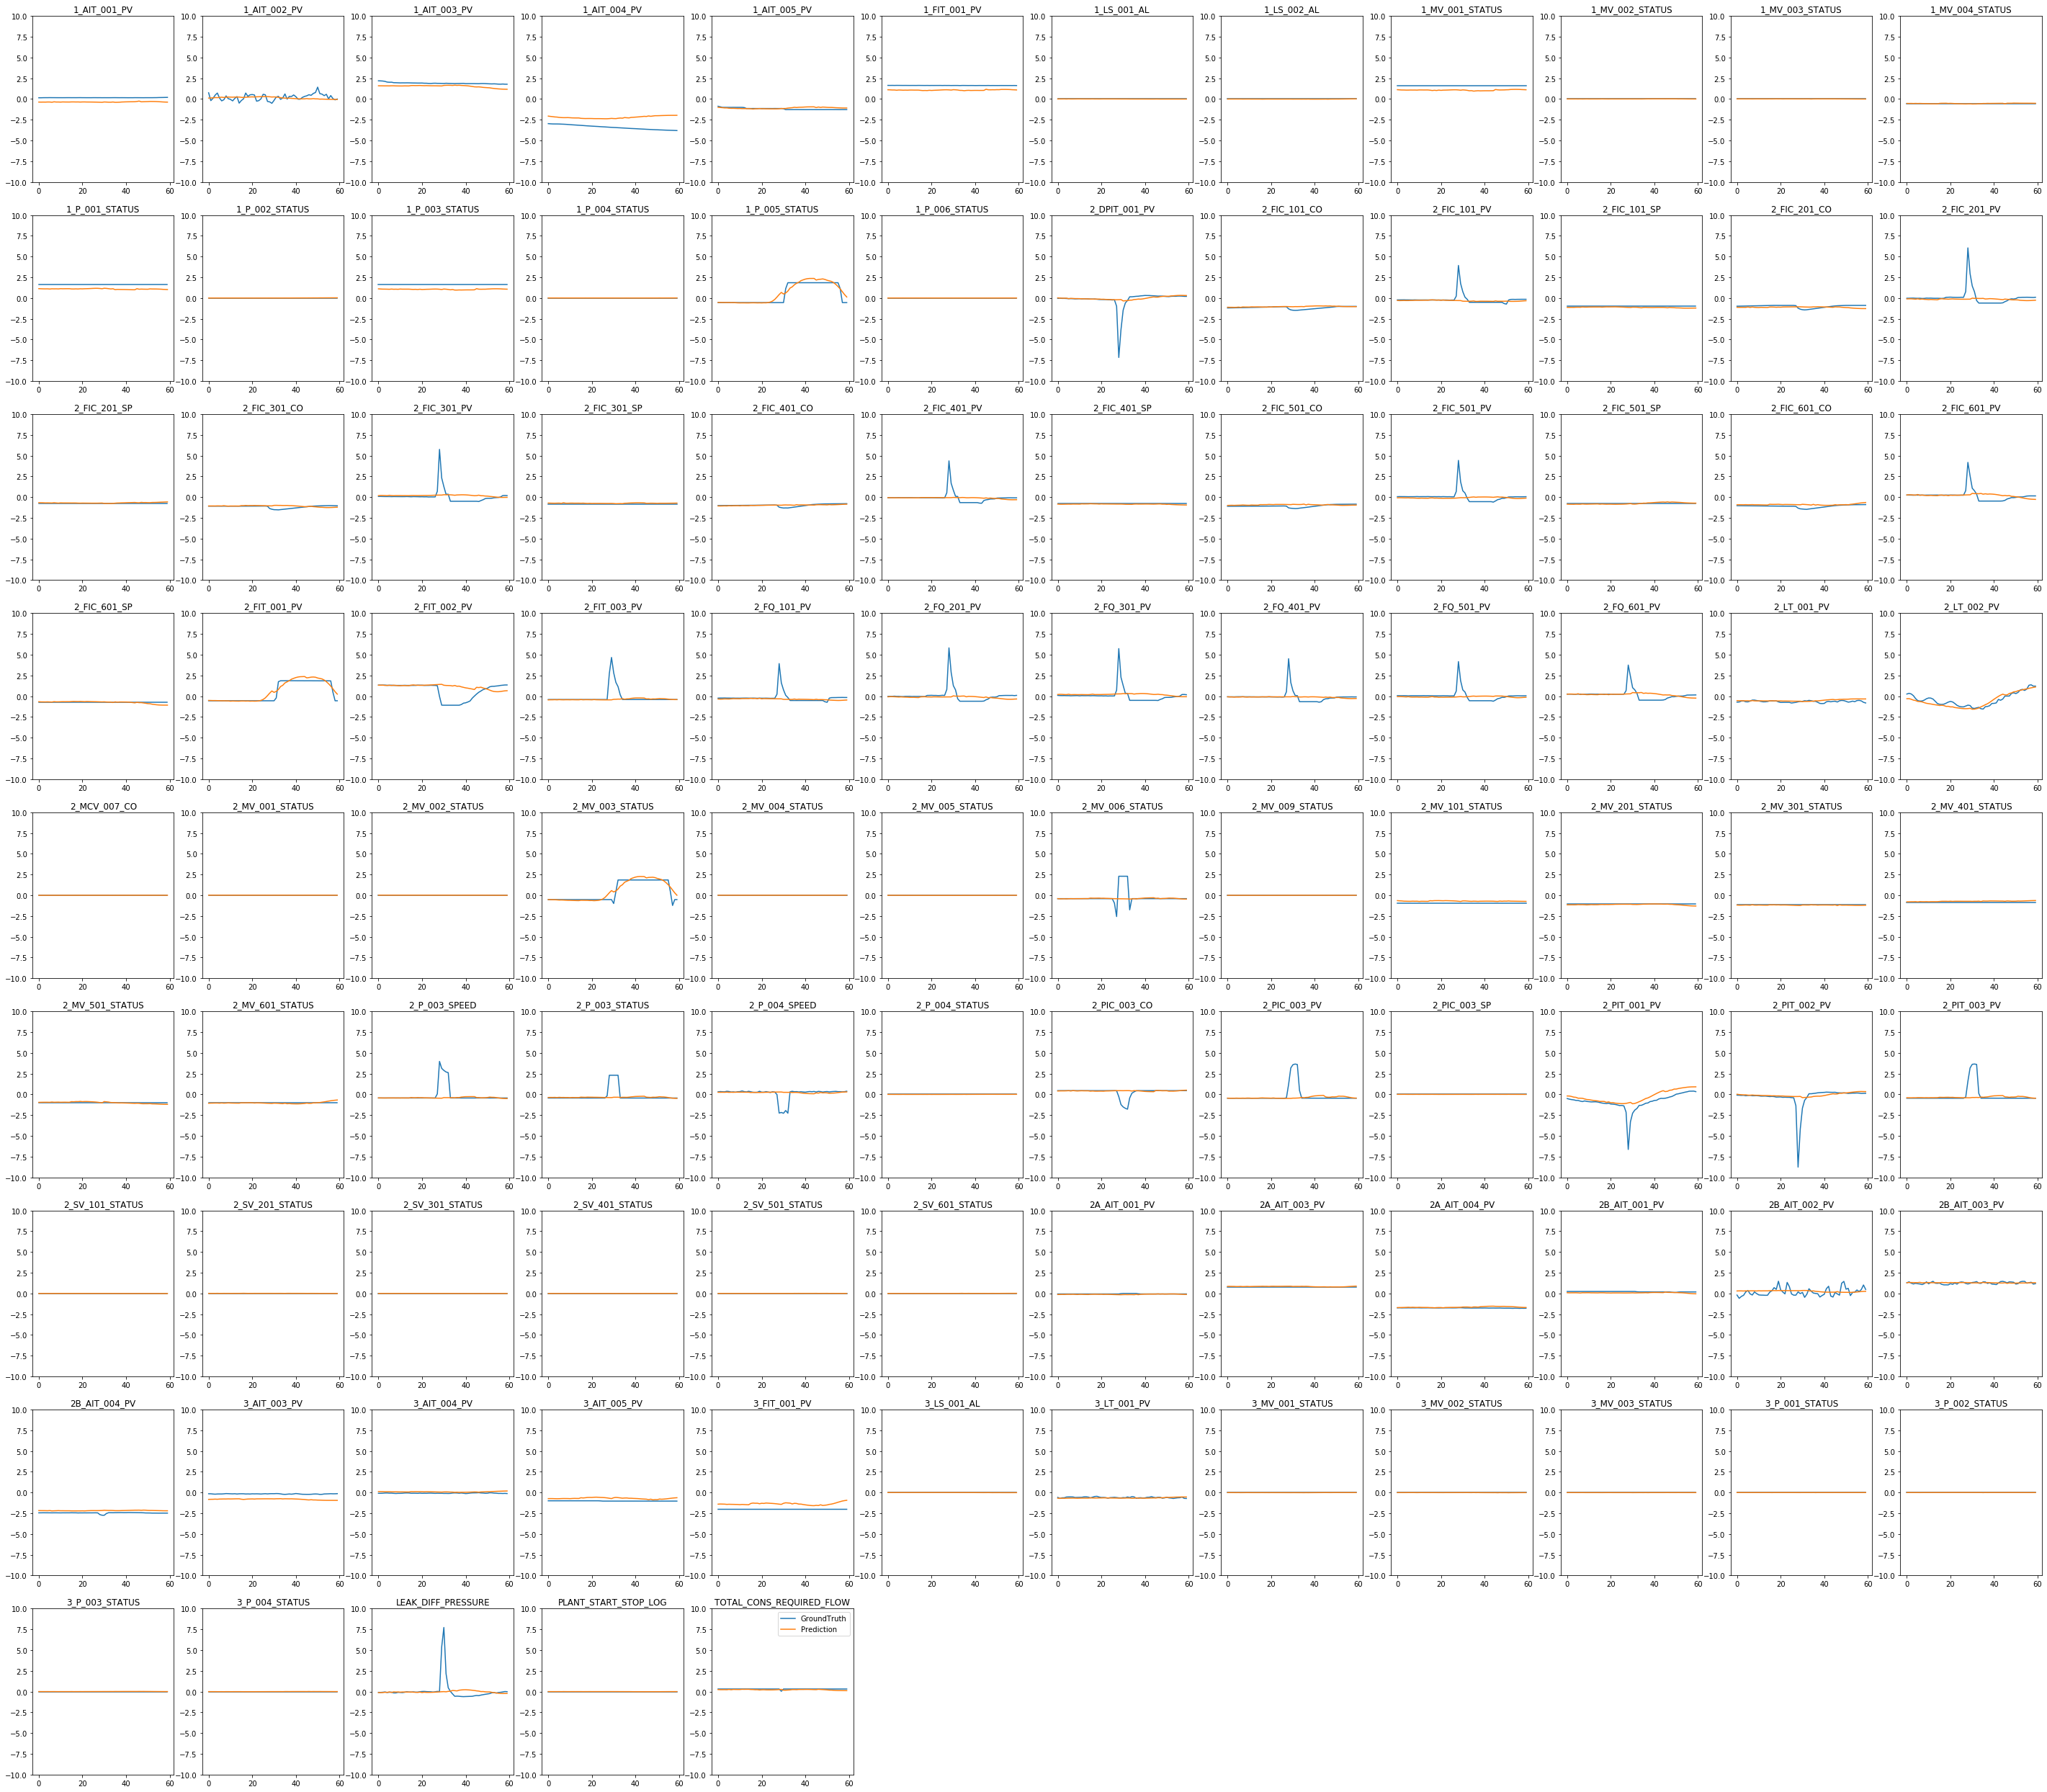

In [33]:
# StandardScaler
# lr=0.0001
# args.seq_len = 6*60*3, args.label_len = 6*60, args.pred_len = 6*30 
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 50))

idx = 3
 
for i in range(args.enc_in):
    plt.subplot(10, 12, i+1)
    plt.ylim([-10.0, 10.0])    
    plt.plot(val_trues[idx,:,i], label='GroundTruth')
    plt.plot(val_preds[idx,:,i], label='Prediction')
    plt.title(f'{norm_data.columns[i]}')

print(list(val_label.iloc[idx*args.pred_len:(idx+1)*args.pred_len, 0]))
plt.legend()
plt.show()

In [22]:
path = './results/anomaly/'+setting
#val_preds = np.load(path+'/val_pred.npy')
#val_trues = np.load(path+'/val_true.npy')
test_preds = np.load(path+'/test_pred.npy')
test_trues = np.load(path+'/test_true.npy')

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


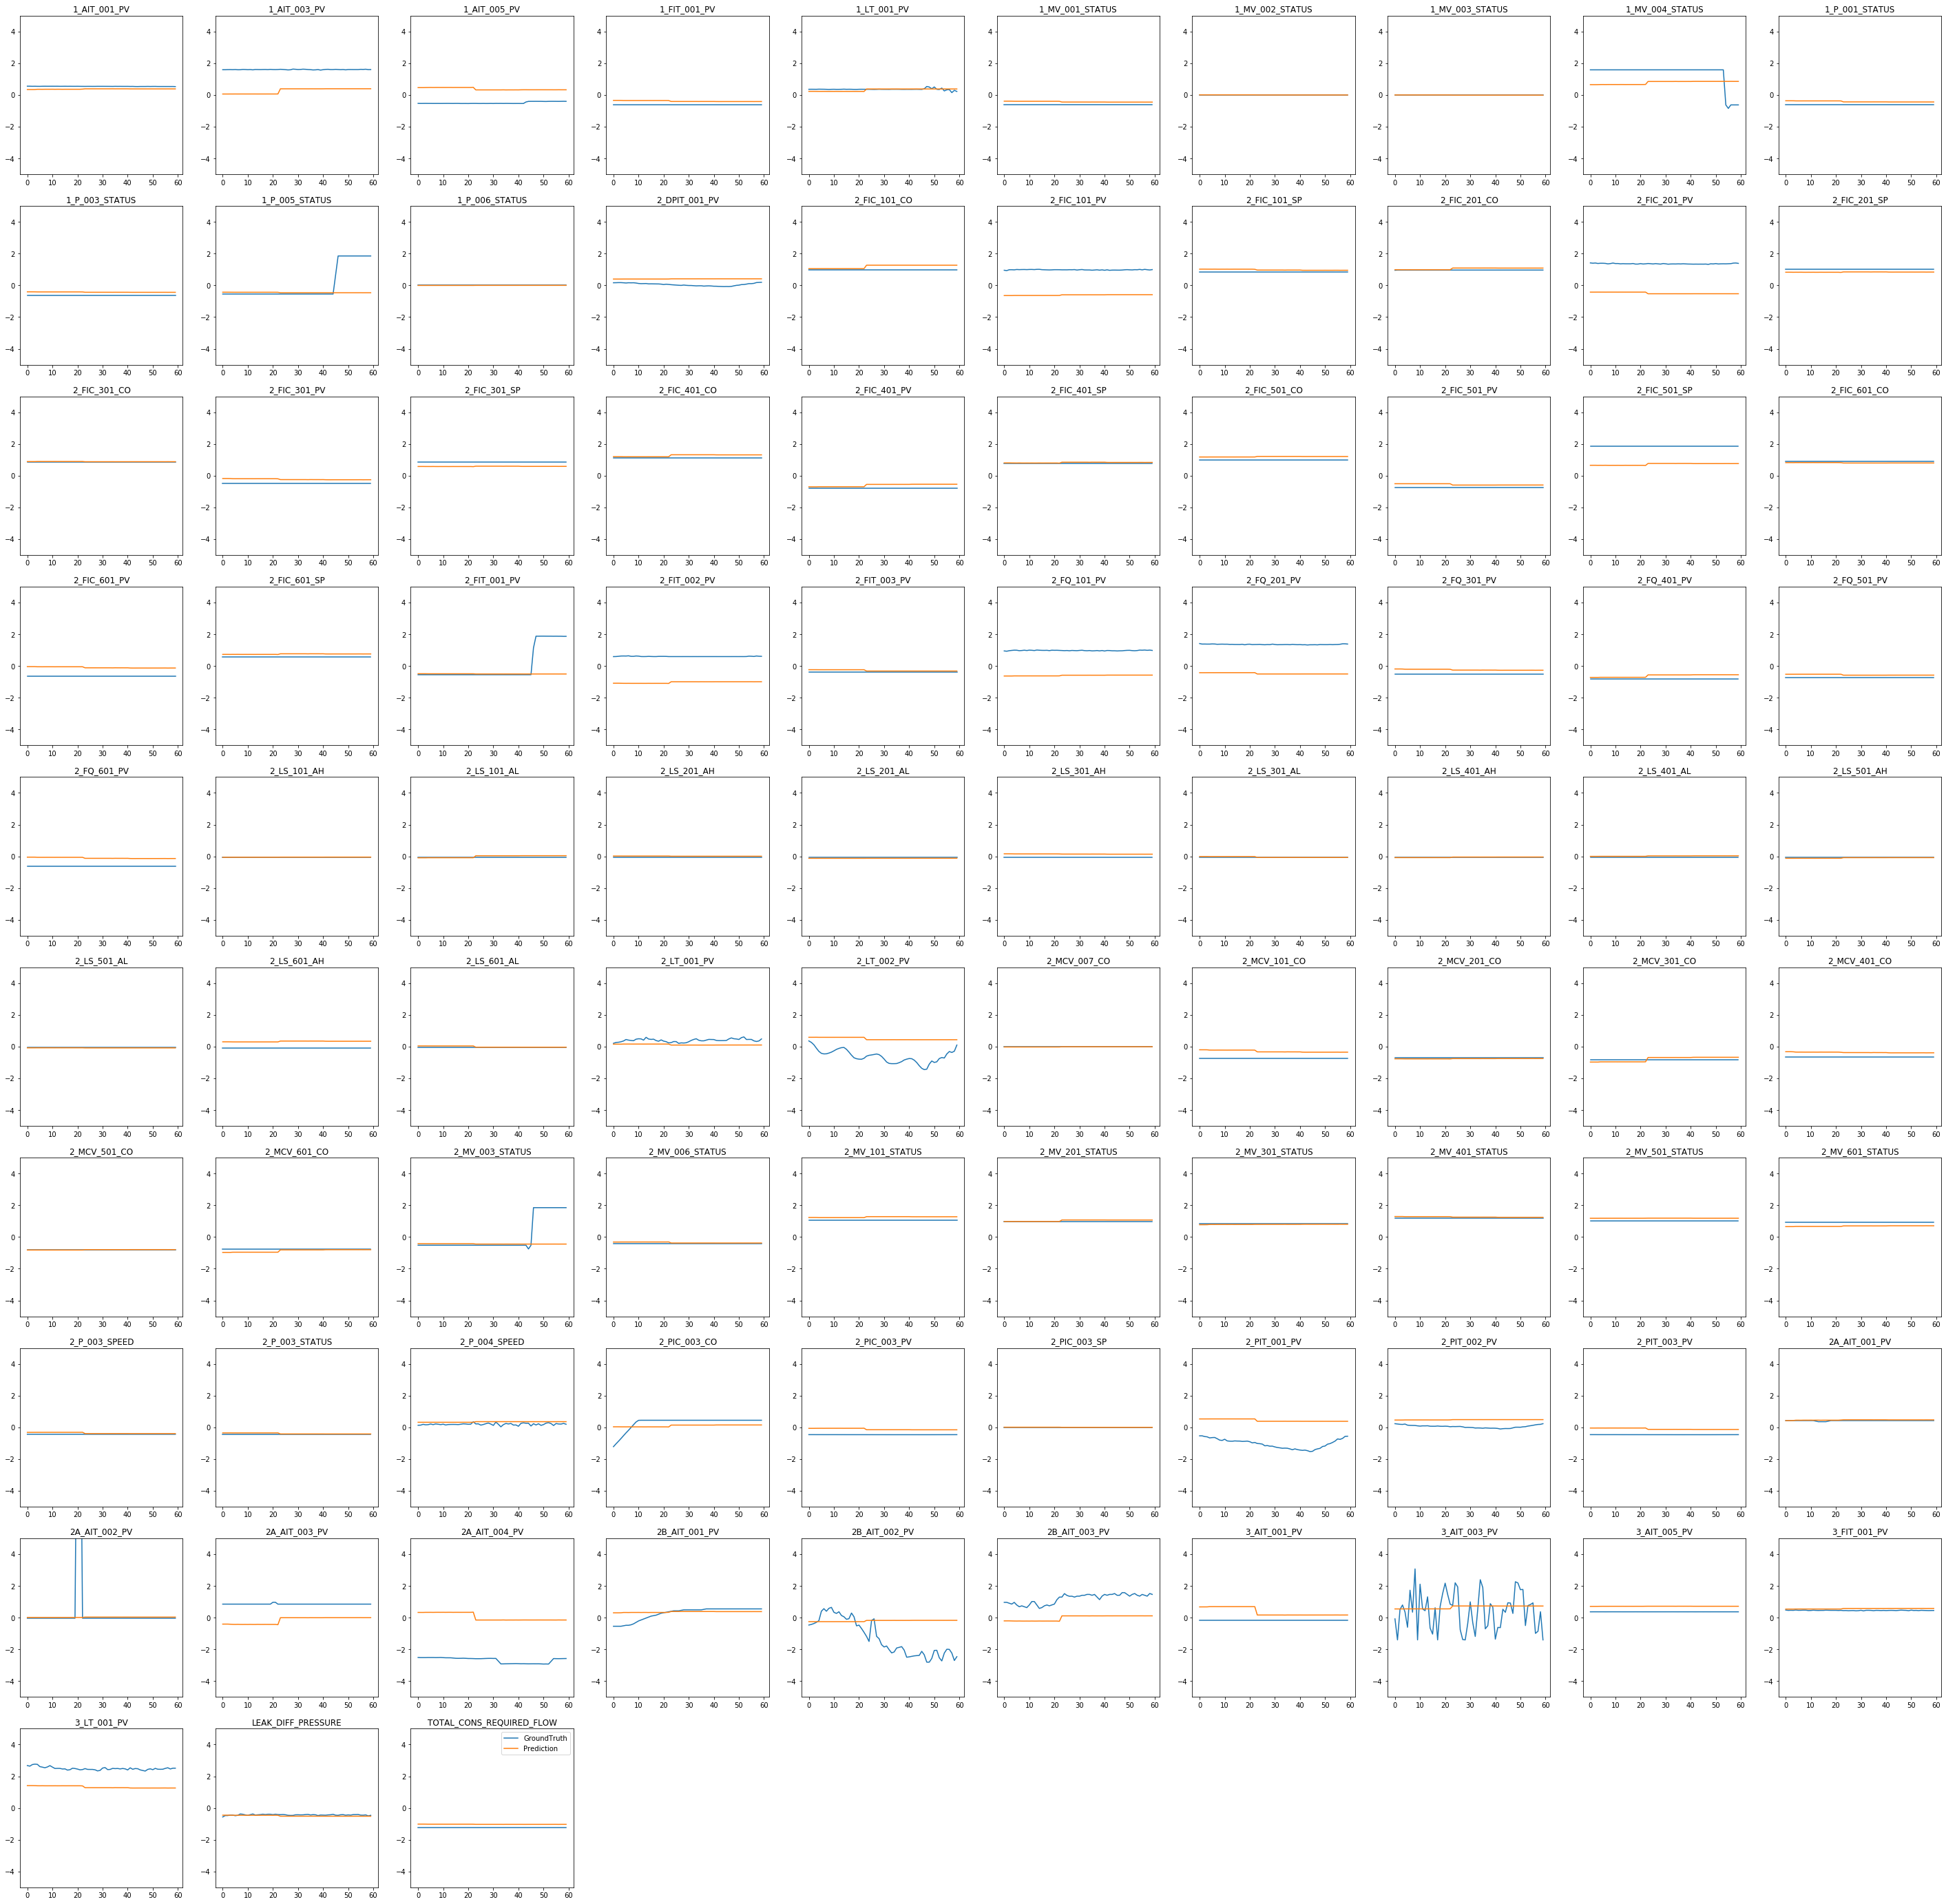

In [25]:
# StandardScaler
# lr=0.0001
# args.seq_len = 6*60*3, args.label_len = 6*60, args.pred_len = 6*30 
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 50))

idx = 10
 
for i in range(args.enc_in):
    plt.subplot(10, 10, i+1)
    plt.ylim([-5.0, 5.0])    
    
    plt.plot(test_trues[idx,:,i], label='GroundTruth')
    plt.plot(test_preds[idx,:,i], label='Prediction')
    plt.title(f'{norm_data.columns[i]}')

print(list(test_label.iloc[idx*60:(idx+1)*60, 0]))
plt.legend()
plt.show()

## 3. Anomaly detection

In [10]:
import pandas as pd
import numpy as np

In [1]:
import tensorflow as tf

In [124]:
val_test_split = 4*24*30*3
#setting = 'informer_ETTm1_ftM_sl1152_ll576_pl48_dm512_nh8_el4_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0'
set_str = setting.split('_')
attn = set_str[-7][2:]
distil = set_str[-4][2:] == 'True'
seq_len = int(set_str[3][2:])
label_len = int(set_str[4][2:])

df_y = pd.read_csv("./dataset/ETDataset/ETT_Attack_label,perc_outlier10,perc_window10,n_std2,min_std3.csv").iloc[:,1]
#df_y.date = pd.to_datetime(df_y.date)
#df_y = df_y.set_index('date')

val_label = df_y[seq_len:val_test_split]
test_label = df_y[val_test_split:]

len_val = val_label.shape[0]
len_test = test_label.shape[0]

path = './results/anomaly/ETTm1/'+attn+','+str(distil)+'/'+setting
val_preds = np.load(path+'/val_pred.npy').reshape(-1,args.c_out)[:len_val]
val_trues = np.load(path+'/val_true.npy').reshape(-1,args.c_out)[:len_val]
test_preds = np.load(path+'/test_pred.npy').reshape(-1,args.c_out)[:len_test]
test_trues = np.load(path+'/test_true.npy').reshape(-1,args.c_out)[:len_test]

val_err = np.abs(val_preds-val_trues)
test_err = np.abs(test_preds-test_trues)

val_label = np.array(val_label)
test_label = np.array(test_label)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation=tf.nn.relu, input_shape=(7,)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(val_err, val_label, epochs=100, batch_size=256, verbose=0, workers=6)

pred = np.argmax(model.predict(test_err), axis=1)
true = test_label

from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
f1 = f1_score(true, pred)
recall = recall_score(true, pred)
precision = precision_score(true, pred)
f1, recall, precision

(0.7685411572942136, 0.6608269096005606, 0.9182083739045764)

In [123]:
setting = 'informer_ETTm1_ftM_sl384_ll192_pl48_dm512_nh8_el4_dl2_df2048_atfull_fc5_ebtimeF_dtFalse_mxTrue_exp_0'

In [88]:
# 실험 결과
# prob,True
# 48 (0.8115064345193036, 0.7512263489838823, 0.8823045267489712)
# 96 (0.7689782519491177, 0.6566222845129642, 0.9277227722772278)
# 192 (0.8127035830618892, 0.6993693062368606, 0.9698736637512148)
# 384 (0.7950558213716108, 0.6986685353889278, 0.9222941720629048)
# 768 (0.7300613496932516, 0.5837421163279608, 0.9742690058479532)
# 1152 (0.7518734388009992, 0.6327960756832516, 0.9261538461538461)

# prob,False
# 48 (0.8086785009861933, 0.7182901191310441, 0.9250902527075813)
# 96 (0.8181456426581775, 0.7203924316748423, 0.9465930018416207)
# 192 (0.7693561532192339, 0.6615276804484933, 0.9191820837390458)
# 384 (0.8313299728576968, 0.7512263489838823, 0.9305555555555556)
# 768 (0.78462174452253, 0.665031534688157, 0.9566532258064516)

# full,True
# 48 (0.8173913043478259, 0.7245970567624387, 0.9374433363553943)
# 96 (0.8031430934656741, 0.680448493342677, 0.9798183652875883)
# 192 (0.7777319587628866, 0.6608269096005606, 0.9448897795591182)
# 384 (0.79050736497545, 0.6769446391030133, 0.9498525073746312)
# 768 (0.791565287915653, 0.6839523475823406, 0.9393647738209817)

# full,False
# 48 (0.8065374382364119, 0.7435178696566223, 0.8812292358803987)
# 96 (0.7766692248656946, 0.7091800981079187, 0.8583545377438507)
# 192 (0.7958155753583883, 0.7196916608269096, 0.889948006932409)
# 384 (0.7685411572942136, 0.6608269096005606, 0.9182083739045764)

(0.7616766467065869, 0.6685353889278206, 0.8849721706864564)

In [ ]:
# 속도 결과
# prob,True
# 48 48.18101096153259
# 96 58.380966901779175
# 192 85.1944
# 384 118.59614
# 768 208.76856
# 1152 307.3436508

# prob,False
# 48 52.29465
# 96 68.99072289
# 192 106.4264254570
# 384 164.08359
# 768 323.649709939

# full,True
# 48 36.5148
# 96 46.04882
# 192 71.73892
# 384 102.61486625671
# 768 197.77892

# full,False
# 48 41.3991
# 96 54.84081
# 192 87.6165452
# 384 144.12467

In [60]:
confusion_matrix(true, pred)

array([[13396,   137],
       [  386,  1041]])